In [118]:
import pandas as pd
import numpy as np
import random
from math import sqrt
from math import e
from math import log
import matplotlib.pyplot as plt
import array
import time

'''IMP:
Units: h * dist - km/s
       h = 100 km/(s*Mpc)'''

pi = np.pi
freq = 5 * 1e12 #Hz. Freq of 60um band
r_s = 5 #in Mpc r_s/h
fm = np.log10(12) #log_10 of 1.2Jy in 0.1 Jy. Flux limit of the sample
L_s = 4*pi*r_s**2 * freq * fm
R_max = 80 #in Mpc
print('Freq:', freq, '\nr_s:', r_s, '\nFlux Limit:', fm)
print('Luminosity cut-off (L_s):', L_s, '\nR_max:', R_max)

data = pd.read_csv("Data/HEASARC/IRAS Galaxies_1.tsv", delimiter = "\t")

Freq: 5000000000000.0 
r_s: 5 
Flux Limit: 1.0791812460476249
Luminosity cut-off (L_s): 1695173937237548.8 
R_max: 80


In [119]:
'''Sorting Data to be used - Part 1'''

objclass = data["class"]
objext = data["extend_flag"]
objredshift = data["helio_velocity"]
objf60qual = data["micron_flux_60_flag"]
objf12_1, objf25_1, objf100_1 = [], [], []
objf60_1 = []

#czarr_i = c * z units km/s
czarr1, czarr = [], []
for i in range(len(objclass)):
    if (objclass[i] == "GALAXY" and objext[i] == 0 and objf60qual[i] == 2 or objf60qual[i] == 3):
        if objredshift[i] == 0.0: continue
        czarr1.append(float(objredshift[i]))
        objf12_1.append(float(data["micron_flux_12"][i]))
        objf25_1.append(float(data["micron_flux_25"][i]))
        objf60_1.append(float(data["micron_flux_60"][i]))
        objf100_1.append(float(data["micron_flux_100"][i]))

objf12, objf25, objf100 = [], [], []
objf60 = []
for i in range(len(czarr1)):
    if (float(czarr1[i]) >= 0.0 and str(czarr1[i]) != 'nan'):
        czarr.append(czarr1[i]) #final zarr to be used
        objf12.append(objf12_1[i])
        objf25.append(objf25_1[i])
        objf60.append(objf60_1[i])
        objf100.append(objf100_1[i])
        
c = 299792458 #m/s Speed of light

zarr = [float(1e3*x/c) for x in czarr] #redshift array
print(len(zarr))

5667


In [120]:
'''Comoving distance from redshift, Chi(z)'''

H0 = 100.
OM_m, OM_r, OM_de, OM_k = 0.28, 8.24e-5, 0.72, 0

def H(z):
    Hz = H0 * (1+z) * sqrt(OM_m*(1+z) + OM_r*(1+z)**2. + OM_de/(1+z)**2. + OM_k)
    return Hz

def dist(z1_, z2_):
    n = 1000
    ztemp = np.empty(n+1)
    h = (z2_ - z1_)/float(n)
    ztemp[0] = z1_
    f_even, f_odd = 0., 0.
    for i in range(1, n+1):
        ztemp[i] = z1_ + float(i) * h
    for i in range(1, int(n/2)):
        zz = ztemp[2*i]
        f_even = f_even + (1. / H(zz))
    for i in range(1, int(n/2)+1):
        zz = ztemp[2*i-1]
        f_odd = f_odd + (1. / H(zz))
    fz1 = (1. / H(z1_))
    fz2 = (1. / H(z2_))
    integral = h/3. * c / 1e3 * (fz1 + 2.*f_even + 4.*f_odd + fz2)
    return integral

#Comoving distance array
distarr = [float(dist(0., x)) for x in zarr] #values in Mpc
print(len(distarr))

5667


In [121]:
'''Sorting Data to be used - Part 2'''

#subset distances in [r_s, R_max] for use in fitting
darr1, obj1f60 = [], []
for i in range(len(distarr)):
    if (distarr[i] >= r_s and distarr[i] <= R_max and objf60[i] >= fm):
        darr1.append(distarr[i])
        obj1f60.append(objf60[i])
print(len(darr1))

3375


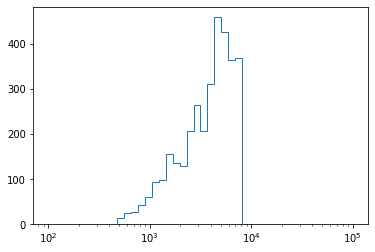

In [122]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.hist(100*np.array(darr1), bins=np.logspace(np.log10(1e2),np.log10(1e5), 45), histtype = 'step')
#ax1.plot(distvals, phivals)
ax1.set_xscale('log')
#ax1.set_ylim(0, 20)
#ax1.set_xlim(0, 1000)
plt.show()

In [130]:
darr2 = np.array(darr1)
print(len(darr2))
f60 = np.array(obj1f60) #in log_10 of flux in 0.1 Jy.

#in Jy
#f60 = 0.1*10**np.array(obj1f60) #in Jy
#fm = 1.2 #in Jy
#L_s = 4*pi*r_s**2 * freq * fm

'''#Remove inf
locinf = np.where(f60 >= 100)
print(locinf)
for i in range(len(locinf)):
    darr2 = np.delete(darr1, locinf[i])
    f60 = np.delete(f60, locinf[i])
print(len(darr2), len(f60))
print(np.where(f60 >= 100))'''

#Luminosities
lumino = 4*pi*darr2**2 * freq * f60

#Yet to convert to numpy arrays
def phi(r, alpha, beta, r_star): #Galaxy Selection function
    A = r_s**(2*alpha) * (1 + (r_s**2./r_star**2.))**beta
    return A * r**(-2*alpha) * (1 + (r**2./r_star**2.))**-beta
#------------------------------

def PSI(L_arr, alpha, beta, r_star): #Cumulative Luminosity function
    L_star = 4*pi*r_star**2. * freq * fm
    C = 1 #
    return C * (L_arr/L_star)**-alpha * (1 + L_arr/L_star)**-beta

def PHI(L_arr, alpha, beta, r_star): #Luminosity function
    L_star = 4*pi*r_star**2. * freq * fm
    return (alpha/L_arr + beta/(L_star + L_arr)) * PSI(L_arr, alpha, beta, r_star)

def probf(r_arr, L_arr, alpha, beta, r_star): #Probability function "f(Li|ri)"
    size = len(r_arr)
    Lm = np.maximum(L_s, 4*pi*r_arr**2 * freq * fm)
    return_array = (L_arr >= Lm) * PHI(L_arr, alpha, beta, r_star) / PSI(Lm, alpha, beta, r_star)
    return return_array
    
#Likelihood function
#returns a POSITIVE value (COST that the algorithm pays at the given vales of parameters)
def lhdfunc(params):
    alpha, beta, r_star = params[0], params[1], params[2]
    f = probf(darr2, lumino, alpha, beta, r_star)
    value = np.sum(np.log(f))
    #print('COST:', -2 * value)
    return -2 * value

3375


In [131]:
####---- Monte-Carlo Minimization ----####

niter = 1e6
i, k = 0, 0
random.seed(0)

alpha, beta, r_star = 0.3, 1.4, 38 #initial guess
#alpha, beta, r_star = 0.1, 0.1, 10 #initial guess
ini_alpha, ini_beta, ini_r_star = alpha, beta, r_star
'''actual values are:
alpha = 0.527, beta = 1.78, r_star = 44'''

acc_alphas, acc_betas, acc_r_stars = np.empty(0), np.empty(0), np.empty(0) #arrays to store all accepted parameter values
costarr = np.empty(0) #array to store cost (from likelihood func) at all accepted values

f_old = lhdfunc(array.array('f', [alpha, beta, r_star])) #OLD COST (from likelihood func)
print('Initial COST:', f_old)

print('\nMCMC Begins!!!\n')

start = time.perf_counter()

while i < int(niter):
    inc_alpha, inc_beta, inc_r_star = random.normalvariate(0, 0.05), \
    random.normalvariate(0, 0.05), random.normalvariate(0, 0.5) #random increments to parameters (from a normal distribution)
    
    guess = array.array('f', [alpha + inc_alpha, beta + inc_beta, r_star + inc_r_star]) #new parameters
    f_new = lhdfunc(guess) #NEW COST (from likelihood func)
    
    #print('f_old =', f_old, 'f_new =', f_new)
    #f_ratio = e**(-f_new) / e**(-f_old) #"Gives wrong value due to large power of e"
    #print('f_ratio =', f_ratio)
    
    differ_f = f_new - f_old #Using difference method as above commented code doesn't work
    
    #if (f_ratio >= 1): #Accept if f_ratio >= 1
    if differ_f <= 0: #"OR" Accept if differ_f <= 0
        alpha, beta, r_star = alpha + inc_alpha, beta + inc_beta, r_star + inc_r_star #Accept the parameters
        acc_alphas = np.insert(acc_alphas, k, alpha)
        acc_betas = np.insert(acc_betas, k, beta)
        acc_r_stars = np.insert(acc_r_stars, k, r_star)
        costarr = np.insert(costarr, k, f_new)
        f_old = f_new #Set new COST as old COST for next iteration
        k += 1
        #print('Accepted')
    
    else: #Accept if uniform random number(u) <= f_ratio
        #"OR" Accept if u <= e**(-differ_f)
        u = random.uniform(0, 1)
        #if (u <= f_ratio):
        if (u <= e**(-differ_f)):
            alpha, beta, r_star = alpha + inc_alpha, beta + inc_beta, r_star + inc_r_star #Accept the parameters
            acc_alphas = np.insert(acc_alphas, k, alpha)
            acc_betas = np.insert(acc_betas, k, beta)
            acc_r_stars = np.insert(acc_r_stars, k, r_star)
            costarr = np.insert(costarr, k, f_new)
            f_old = f_new #Set new COST as old COST for next iteration
            k += 1
            #print('Accepted')
        '''else:
            acc_alphas.append(alpha)
            acc_betas.append(beta)
            acc_r_stars.append(r_star)
            costarr.append(f_old)
            #print('Rejected')'''
    
    i += 1
    if (i % 1e4 == 0):
        print('Iter: %d K, \tcurrent acc_ratio = %.3f' % (i/1e3, k/i))
        print(f_old)

seconds = time.perf_counter() - start

accratio = k/niter
print("\nNumber of accepted values:", k)
print("Acceptance ratio is", accratio)

print("\nCOST at the end:", lhdfunc(array.array('f', [alpha, beta, r_star])))

print("\nTime = %.2f seconds" % seconds)

#Redundant code
#guess = np.array([0.5, 1.7, 4400])
#results = minimize(lhdfunc, guess, options={'disp': True})

Initial COST: 274553.73985877086

MCMC Begins!!!

Iter: 10 K, 	current acc_ratio = 0.246
274517.79631715716
Iter: 20 K, 	current acc_ratio = 0.250
274519.45100345626
Iter: 30 K, 	current acc_ratio = 0.249
274520.0073111019
Iter: 40 K, 	current acc_ratio = 0.249
274518.13488612795
Iter: 50 K, 	current acc_ratio = 0.249
274518.9697556461
Iter: 60 K, 	current acc_ratio = 0.249
274518.19055390765
Iter: 70 K, 	current acc_ratio = 0.249
274517.6070696326
Iter: 80 K, 	current acc_ratio = 0.250
274518.01411163935
Iter: 90 K, 	current acc_ratio = 0.249
274518.1581920065
Iter: 100 K, 	current acc_ratio = 0.249
274517.3218967569
Iter: 110 K, 	current acc_ratio = 0.249
274518.41399428784
Iter: 120 K, 	current acc_ratio = 0.250
274519.37118579756
Iter: 130 K, 	current acc_ratio = 0.250
274518.3037977166
Iter: 140 K, 	current acc_ratio = 0.250
274518.42999602435
Iter: 150 K, 	current acc_ratio = 0.250
274517.6238311324
Iter: 160 K, 	current acc_ratio = 0.250
274517.79244681704
Iter: 170 K, 	current 

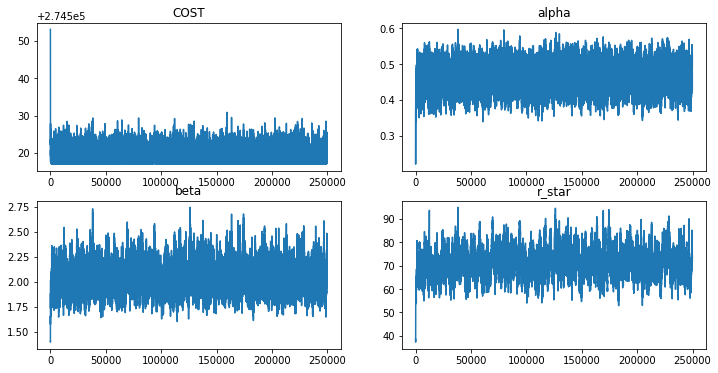

In [132]:
limit = k

figure = plt.figure(figsize = (12, 6))

ax1 = figure.add_subplot(221)
ax1.plot(costarr[:limit])
ax1.set_title('COST')

ax2 = figure.add_subplot(222)
ax2.plot(acc_alphas[:limit])
ax2.set_title('alpha')

ax3 = figure.add_subplot(223)
ax3.plot(acc_betas[:limit])
ax3.set_title('beta')

ax4 = figure.add_subplot(224)
ax4.plot(acc_r_stars[:limit])
ax4.set_title('r_star')

plt.show()

In [133]:
#Mean and Standard-deviation of Accepted Parameter Values

burn_end = 1500
mean_alpha, std_alpha = np.mean(acc_alphas[burn_end:limit]), np.std(acc_alphas[burn_end:limit])
mean_beta, std_beta = np.mean(acc_betas[burn_end:limit]), np.std(acc_betas[burn_end:limit])
mean_r_star, std_r_star = np.mean(acc_r_stars[burn_end:limit]), np.std(acc_r_stars[burn_end:limit])
print('alpha \t= %.4f +- %.4f' % (mean_alpha, std_alpha))
print('beta \t= %.4f +- %.4f' % (mean_beta, std_beta))
print('r_star \t= %.4f +- %.4f' % (mean_r_star, std_r_star))

alpha 	= 0.4640 +- 0.0294
beta 	= 2.0477 +- 0.1321
r_star 	= 71.3751 +- 5.8127


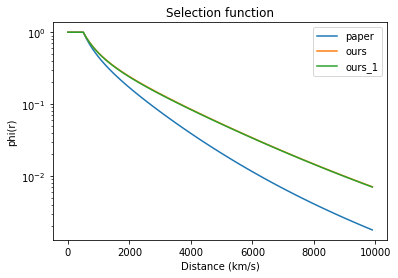

In [134]:
#Plot Selection Function

#distvals = np.logspace(np.log10(1e2),np.log10(1e5), 45)
distvals = np.arange(5, 100, 1)
distvalsplot = np.arange(0, 10000, 100)

alpha_val, beta_val, r_star_val = 0.527, 1.78, 44
phivals_paper = [phi(x, alpha_val, beta_val, r_star_val) for x in distvals]
phivals_paper = np.insert(phivals_paper, 0, [1, 1, 1, 1, 1])

alpha_val, beta_val, r_star_val = 0.4576, 2.0152, 69.6566
phivals_mine = [phi(x, alpha_val, beta_val, r_star_val) for x in distvals]
phivals_mine = np.insert(phivals_mine, 0, [1, 1, 1, 1, 1])

alpha_val, beta_val, r_star_val = mean_alpha, mean_beta, mean_r_star
phivals_mine_1 = [phi(x, alpha_val, beta_val, r_star_val) for x in distvals]
phivals_mine_1 = np.insert(phivals_mine_1, 0, [1, 1, 1, 1, 1])

plt.plot(distvalsplot, phivals_paper, label = 'paper')
plt.plot(distvalsplot, phivals_mine, label = 'ours')
plt.plot(distvalsplot, phivals_mine_1, label = 'ours_1')
plt.yscale('log')
plt.legend()
plt.title('Selection function')
plt.xlabel('Distance (km/s)')
plt.ylabel('phi(r)')
plt.savefig('selection_fn_paper+ours')
plt.show()

In [135]:
#Save accepted parameter lists

np.savez('New_MC_initialchain_IC_alpha_%.2f_beta_%.2f_rstar_%.2f_iter_%d.npz' % (ini_alpha, ini_beta, ini_r_star, niter),
         burn = burn_end,
         ini_alpha = ini_alpha,
         ini_beta = ini_beta,
         ini_r_star = ini_r_star,
         mean_alpha = mean_alpha,
         std_alpha = std_alpha,
         mean_beta = mean_beta,
         std_beta = std_beta,
         mean_r_star = mean_r_star,
         std_r_star = std_r_star,
         alpha_arr = acc_alphas,
         beta_arr = acc_betas,
         r_star_arr = acc_r_stars,
         acc_ratio = accratio
        )
print('Okay! Saved!')

Okay! Saved!


# REDUNDANT CODES START HERE!!!!!

(0, 0.01)

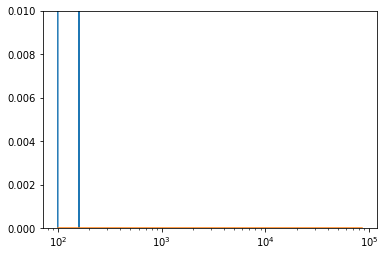

In [98]:
distvals = np.logspace(np.log10(1e2),np.log10(1e5), 45)
phivals = [phi(x, alpha, beta, r_star) for x in distvals]


hist, bin_edges = np.histogram(100*np.array(distarr), bins = distvals)
plt.plot(bin_edges[:-1], hist)
plt.plot(bin_edges[:-1], np.array(phivals[:-1]))
plt.xscale('log')
plt.ylim(0, 0.01)

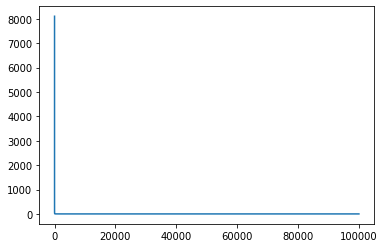

In [96]:
n1 = 

#byphivals = [1/x for x in phivals]
plt.plot(distvals, phivals)
plt.xscale('log')
plt.show()

In [116]:
for i in range(len(distarr)):
    if distarr[i] < r_s

TypeError: '<' not supported between instances of 'list' and 'int'

In [167]:
'''nintbin = 10
intdistarr = []
for i in range(len(distvals) - 1):
    intdistarr.extend(np.linspace(distvals[i], distvals[i+1], nintbin))
lumintdist = [4*np.pi*intdistarr[i]**2 * freq * f60[i] for i in range(len(distarr))]
    
densityvals = []
i, k = 0, 0
while i < len(distvals):
    for j in range(nintbin):
        densityvals[k] += PHI()'''

0.0

In [192]:
np.array([1, 2])/np.array([2, 4])

array([0.5, 0.5])

(0, 20)

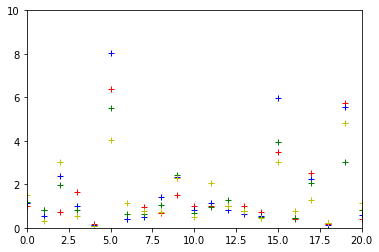

In [201]:
#plt.plot(objf12, 'ro')
#plt.plot(objf25, 'bo')
plt.plot(np.array(objf12[:-1])/np.array(objf12[1:]), 'r+')
plt.plot(np.array(objf25[:-1])/np.array(objf25[1:]), 'b+')
plt.plot(np.array(objf60[:-1])/np.array(objf60[1:]), 'g+')
plt.plot(np.array(objf100[:-1])/np.array(objf100[1:]), 'y+')
#plt.plot(objf100, 'go')
plt.ylim(0, 10)
plt.xlim(0, 20)

In [73]:
random.normalvariate(0, 0.01)

0.003216231249070716

In [90]:
array.array('', [1., 2, 3])

TypeError: integer argument expected, got float

In [12]:
less = 0
for i in range(len(f60)):
    if np.log10(12) > f60[i]: less += 1
less

172

In [13]:
len(f60)

3547

/home/pallav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

False